## Setup for NB Section

In [1]:
# Import Packages
#!pip install xgboost
#!brew install libomp
# import kaggle
import numpy as np
import pandas as pd
import re 

# Learning libs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

# PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.feature_selection import RFE, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Producing Decision Tree diagrams
from IPython.display import Image, display
import pydotplus
from subprocess import call

# For other 
import copy
from textwrap import wrap

np.random.seed(0)

In [2]:
train_data = pd.read_csv('../data/processed/train_data.csv').set_index('Id')
train_labels = pd.read_csv('../data/processed/train_labels.csv').set_index('Id')
dev_data = pd.read_csv('../data/processed/dev_data.csv').set_index('Id')
dev_labels = pd.read_csv('../data/processed/dev_labels.csv').set_index('Id')

In [3]:
train = train_data.merge(train_labels, how = 'left', on = train_data.index)\
        .set_index(train_data.index)\
        .drop(['key_0'], axis = 1)

dev = dev_data.merge(dev_labels, how = 'left', on = dev_data.index)\
        .set_index(dev_data.index)\
        .drop(['key_0'], axis = 1)

In [4]:
print("Train_data and Dev_data: for models, does not include labels in DF")
print(train_data.shape)
print(dev_data.shape)
print(train_labels.shape)
print(dev_labels.shape)

print("\nTrain and Dev: for EDA, includes labels in DF for easy plotting")
print(train.shape)
print(dev.shape)

Train_data and Dev_data: for models, does not include labels in DF
(12096, 54)
(3024, 54)
(12096, 1)
(3024, 1)

Train and Dev: for EDA, includes labels in DF for easy plotting
(12096, 55)
(3024, 55)


In [5]:
# Zero values 
# ------------------------------------------------------------------------------
zero_counts = pd.DataFrame({'zeros':train_data[train_data == 0].count(), 'total':train_data.count()})

zero_features = zero_counts[zero_counts.zeros == zero_counts.total].index.to_list()
zero_counts.head()

,zeros,total
Elevation,0,12096
Aspect,91,12096
Slope,4,12096
Horizontal_Distance_To_Hydrology,1267,12096
Vertical_Distance_To_Hydrology,1500,12096


In [6]:
train_data.drop(columns = zero_features, inplace = True)
dev_data.drop(columns = zero_features, inplace = True)

In [7]:
# Total_Distance_to_Hydrology
# ------------------------------------------------------------------------------
# Create Total_Distance_to_Hydrology based on Euclidean distance
train_data['Total_Distance_To_Hydrology'] = np.sqrt(train_data["Horizontal_Distance_To_Hydrology"]**2 + train_data['Vertical_Distance_To_Hydrology']**2)
dev_data['Total_Distance_To_Hydrology'] = np.sqrt(dev_data["Horizontal_Distance_To_Hydrology"]**2 + dev_data['Vertical_Distance_To_Hydrology']**2)
train_data[["Total_Distance_To_Hydrology", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology"]].head()

,Total_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology
Id,,,
4429,0.000000,0,0
12400,0.000000,0,0
4648,215.564376,192,98
5954,0.000000,0,0
2947,0.000000,0,0


In [8]:
continuous_features = list(train_data.columns[0:10]) + ['Total_Distance_To_Hydrology']
binary_features = train_data.columns[10:-1].to_list()

continuous_index = [train_data.columns.tolist().index(f) for f in continuous_features]
binary_index = [train_data.columns.tolist().index(f) for f in binary_features]

print(train_data.iloc[:,continuous_index].columns)
print(train_data.iloc[:,binary_index].columns)
print(continuous_index)

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Total_Distance_To_Hydrology'],
      dtype='object')
Index(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       '

In [9]:
# Transform continuous features to normalize
X_train = train_data[continuous_features + binary_features]
X_dev = dev_data[continuous_features + binary_features]
X_train.shape

ct = ColumnTransformer([
        ('features', StandardScaler(), continuous_features)
        ], remainder='passthrough')
nX_train = ct.fit_transform(X_train)
nX_dev = ct.transform(X_dev)
pd.DataFrame(nX_train, columns = X_train.columns).loc[:,continuous_features].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Total_Distance_To_Hydrology
count,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04,1.209600e+04
mean,2.946827e-16,-3.465776e-17,1.373552e-16,-1.859917e-16,-5.837482e-18,-1.061531e-16,2.473817e-16,2.816367e-16,1.872538e-16,5.739617e-17,-1.657625e-16
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-2.124240e+00,-1.423808e+00,-1.955819e+00,-1.083077e+00,-3.209591e+00,-1.298828e+00,-6.906541e+00,-5.260928e+00,-2.949754e+00,-1.380555e+00,-1.096632e+00
25%,-8.952984e-01,-8.337014e-01,-7.719155e-01,-7.639456e-01,-7.497377e-01,-7.188853e-01,-5.362354e-01,-5.247223e-01,-6.176491e-01,-7.119251e-01,-7.838265e-01
50%,5.446341e-03,-2.799089e-01,-1.799639e-01,-2.257094e-01,-3.098964e-01,-3.022646e-01,2.438020e-01,1.769377e-01,5.800748e-02,-2.344632e-01,-2.249585e-01
75%,8.463011e-01,9.456974e-01,6.487684e-01,4.887633e-01,4.720437e-01,4.205838e-01,7.313254e-01,7.031828e-01,7.118686e-01,4.371392e-01,4.928629e-01
max,2.633417e+00,1.844475e+00,4.200478e+00,5.313836e+00,8.193702e+00,3.910823e+00,1.348855e+00,1.536404e+00,2.455498e+00,4.887734e+00,5.204268e+00


In [10]:
# Relabel outcome variable - check match
y_train = train_labels.Cover_Type
y_dev = dev_labels.Cover_Type

print(X_train.shape)
print(nX_train.shape)
print(X_dev.shape)
print(nX_dev.shape)

(12096, 52)
(12096, 52)
(3024, 52)
(3024, 52)


## Naive Bayes Models

### Model Strategy and Results

Our first attempt for modeling this problem involved using the Naive Bayes classifier. Based on the course content and additional research that we had done, we believed that while Naive Bayes tends to be overconfident about results, the classifier tends to generalize well to different data sets.

We realized quickly, however, that our set of data includes both binary and continuous variables, which makes it more difficult to produce a Naive Bayes model. A Gaussian Naive Bayes model requires the use of continuous data, and a Bernoulli Naive Bayes model requires the data to be binary (or ordered, in the case of using a Multinomial model). There is not one model that utilizes both continuous and binary data.

One option we had was to convert the continuous data into binary or multinomial data, which would result in a loss of information, but may simplify the model so that it generalizes better. Another option we looked into was combining the results of a Bernoulli model with the results of a Gaussian model. Other attempts at improving our F1 Score and accuracy included smoothing the model, transforming our continuous features using the Yeo-Johnson method, and removing subsets of features. After extensive model tuning, we found that we could only reach a maximum F1 score of **63.9%** and an accuracy of **63.7%** using the Naive Bayes Classifier. While this in part could be due to having two classes of data, we believe that this data set also violates the independence assumption required for a Naive Bayes model, in which features are assumed to be independent. Based on our scatterplots above, it may be the case that our features are too closely related. 

A summary of our modeling iterations is presented in this section below, but a more detailed description of our results can be found in the Appendix at the end of this document.


**[INSERT RESULTS BELOW - MODEL TYPES AND SCORES]**

### [All that follows below will be in our Appendix]

Our features are represented by two different classes of data. We have **continuous variables** (elevation, aspect, slope, horizontal/vertical distance to hydrology, horizontal distance to roadways, hillshade, horizontal distance to fire points), and **binary variables** (wilderness areas, soil types), all of which are associated with 7 different tree cover types.

Because there is a mix of continuous/binary variables, we cannot just use a Gaussian (continuous) or Bernoulli (binary) Naive Bayes.

As a first pass, we train and evaluate models on the subsets of features that immediately fit into the models.

Later, feature selection, transformation, etc. will be performed to allow for combinations of such features into a single Naive Bayes Model.

#### Implement Gaussian Naive Bayes with strictly continuous features

In [11]:
# For NB, we will remove 'Total_Distance_to_Hydrology'
continuous_features.remove('Total_Distance_To_Hydrology') 

In [12]:
# Fit Gaussian Naive Bayes
gausNB = GaussianNB().fit(X_train[continuous_features], np.array(y_train).ravel())          # Fit
gausNB_pred = gausNB.predict(X_dev[continuous_features])                  # Predict

gausNB_f1 = metrics.f1_score(y_dev, gausNB_pred, average = 'weighted')    # F1
gausNB_accur = gausNB.score(X_dev[continuous_features], y_dev)            # Accuracy

print('Gaussian Naive Bayes (Only Continuous Features)')
print(f'F1: {gausNB_f1:.3f} \nAccuracy: {gausNB_accur:.3f}')

Gaussian Naive Bayes (Only Continuous Features)
F1: 0.583 
Accuracy: 0.592


#### Implement Bernoulli Naive Bayes with strictly binary features

In [13]:
# Fit Bernoulli Naive Bayes
bNB = BernoulliNB().fit(X_train[binary_features], np.array(y_train).ravel())          # Fit
bNB_pred = bNB.predict(X_dev[binary_features])                      # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')    # F1
bNB_accur = bNB.score(X_dev[binary_features], y_dev)                # Accuracy

print('Bernoulli Naive Bayes (Only Binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (Only Binary features)
F1: 0.578 
Accuracy: 0.583


#### Combine the results of a Bernoulli Model and a Gaussian Model

In [14]:
# Get probability predictions for each model
# On training data
G_train_probs = gausNB.predict_proba(X_train[continuous_features])
C_train_probs = bNB.predict_proba(X_train[binary_features])

# On dev data
G_dev_probs = gausNB.predict_proba(X_dev[continuous_features])
C_dev_probs = bNB.predict_proba(X_dev[binary_features])

# Combine probability prediction for class=1 from both models into a 2D array
# np.c_ translates slice objects to concatenation along the second axis.
X_new_train = np.c_[(G_train_probs[:,1], C_train_probs[:,1])] # Train
X_new_dev = np.c_[(G_dev_probs[:,1], C_dev_probs[:,1])] # Dev

# Fit final Gaussian model
# Using the probabilities from the last two modes as input
model = GaussianNB().fit(X_new_train, y_train)

# Predict class labels on dev data
pred_labels_dev = model.predict(X_new_dev)

combined_f1 = metrics.f1_score(y_dev, pred_labels_dev, average = 'weighted') 
combined_score = model.score(X_new_dev, y_dev)

print('Combined Gaussian and Bernoulli Probability Model')
print(f'F1: {combined_f1:.3f} \nAccuracy: {combined_score:.3f}')

Combined Gaussian and Bernoulli Probability Model
F1: 0.311 
Accuracy: 0.356


The combined model does extremely worse, with an F1 score of 0.311 and an accuracy of 0.356. This is unacceptable for a predictive model, so we will move away from this method. Next, we will attempt to binarize the continuous variables to input into a Bernoulli model.

#### Binarize Continuous Features

Even despite the combined model's unacceptable accuracy, we can still see that separately, the Gaussian model and the Bernoulli model does a poor job of prediction, each under 60% accuracy. Let's try to binarize some of the continuous variables across their means.

In [15]:
# Find mean of each continuous column and append to list
mean_list = []
for feature in continuous_features:
    mean_list.append(np.mean(X_train[feature]))

# Define function to binarize on the mean (referenced Week 2 Tutorial)
def binarize_data(data, feature_cols, thresholds = mean_list):
    '''
    Purpose: binarize continuous features, where 0 represents below (or equal to) mean, 1 represents above mean
    Input: continuous feature columns, names of features to be binarized, thresholds for binarization
    Output: binarized feature columns, same shape of input
    '''
    
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = data.copy() # avoid changing the original data

    # Apply a threshold  to each feature.
    i = 0
    for feature in feature_cols:
        binarized_data[feature] = 1 * (binarized_data[feature] > thresholds[i])
        i+=1
    return binarized_data

#### Test a Bernoulli NB model with Binarized + Binary Features

In [16]:
# Transform the continuous variables to binary
bin_train_X = binarize_data(X_train, continuous_features) # Binarize all continuous features
bin_dev_X = binarize_data(X_dev, continuous_features)

# Fit Bernoulli Naive Bayes
bNB2 = BernoulliNB().fit(bin_train_X, np.array(y_train).ravel())     # Fit
bNB_pred2 = bNB2.predict(bin_dev_X)                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred2, average = 'weighted')    # F1
bNB_accur = bNB2.score(bin_dev_X, y_dev)                             # Accuracy

print('Bernoulli Naive Bayes (All features binarized + Binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')
binary_features

Bernoulli Naive Bayes (All features binarized + Binary features)
F1: 0.610 
Accuracy: 0.617


['Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4',
 'Soil_Type1',
 'Soil_Type2',
 'Soil_Type3',
 'Soil_Type4',
 'Soil_Type5',
 'Soil_Type6',
 'Soil_Type9',
 'Soil_Type10',
 'Soil_Type11',
 'Soil_Type12',
 'Soil_Type13',
 'Soil_Type14',
 'Soil_Type16',
 'Soil_Type17',
 'Soil_Type18',
 'Soil_Type19',
 'Soil_Type20',
 'Soil_Type21',
 'Soil_Type22',
 'Soil_Type23',
 'Soil_Type24',
 'Soil_Type25',
 'Soil_Type26',
 'Soil_Type27',
 'Soil_Type28',
 'Soil_Type29',
 'Soil_Type30',
 'Soil_Type31',
 'Soil_Type32',
 'Soil_Type33',
 'Soil_Type34',
 'Soil_Type35',
 'Soil_Type36',
 'Soil_Type37',
 'Soil_Type38',
 'Soil_Type39',
 'Soil_Type40']

Notice there are only marginal returns to accuracy after adding in binarized features. This could be for a number of reasons, but is most likely due to the distribution of each continuous variable. When we split on mean, we are making some assumption that this is a "good" split, which mostly relies on a bell-shaped distribution across the features with mean falling roughly in the middle.

What if we only binarize the features that are well distributed?

#### Test a Bernoulli NB model with only well-distributed features binarized

In [17]:
some_features = ['Elevation', 'Slope', 'Vertical_Distance_To_Hydrology', 'Hillshade_3pm']
model_features = some_features + binary_features
# model_features = some_features + binary_features[:13] + binary_features[14:]

# Transform the continuous variables to binary
bin_train_X = binarize_data(X_train, some_features) # Binarize a subset of continuous features
bin_dev_X = binarize_data(X_dev, some_features)

# Fit Bernoulli Naive Bayes
bNB2 = BernoulliNB().fit(bin_train_X, np.array(y_train).ravel())     # Fit
bNB_pred2 = bNB2.predict(bin_dev_X)                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred2, average = 'weighted')    # F1
bNB_accur = bNB2.score(bin_dev_X, y_dev)                             # Accuracy

print('Bernoulli Naive Bayes (Some features binarized + Binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (Some features binarized + Binary features)
F1: 0.639 
Accuracy: 0.637


#### Transform continuous features based on quantiles

Binarizing the continuous features may be too simple, resulting in too much information loss. Instead, we'll take the continuous features and transform them into multinomial data based on quantiles.

In [18]:
'''
Creating thresholds based on quantiles
'''
def define_thresholds(data, num_divisions):
    thresholds = np.zeros([len(data.columns), num_divisions-1])
    step = round(1/num_divisions,2)
    prev = 0
    bins = []
    for i in range(num_divisions-1):
        num = prev
        bins.append(num+step)
        prev = num+step
    print("Quantiles Chosen:", bins, '\n')
    
    i = 0
    for item in data.columns:
        for j in range(len(bins)):
            thresholds[i][j] = int(data[item].quantile(bins[j]))
        i+=1
    return thresholds

''' 
Convert Continuous Dataframe to Multifeature Dataframe

threshold:    NxM array, N = number of columns, M = number of bins
inputs:       dataframe, threshold values
outputs:      new dataframe
'''
def multifeature(data, thresholds):
    # capture column names
    features = list(data.columns)
    
    # initiate a new dataframe 
    new_df = data.copy()

    i=0
    # bin the data
    for feature in features:
        new_df[feature] = np.digitize(np.array(data[feature]), thresholds[i])
        i+=1
        
    return new_df

num_divisions = 4
thresholds = define_thresholds(X_train[continuous_features], num_divisions)
print("Thresholds for Train Data:\n", thresholds, '\n')
train_df = multifeature(X_train[continuous_features], thresholds)
dev_df = multifeature(X_dev[continuous_features], thresholds)

# This will merge our newly created multinomial features with the original binary features
Xtrain_multi = pd.merge(train_df, X_train[binary_features], left_on='Id', right_on='Id', how='left')
Xtrain_multi.shape

Xdev_multi = pd.merge(dev_df, X_dev[binary_features], left_on='Id', right_on='Id', how='left')
Xdev_multi.shape

Quantiles Chosen: [0.25, 0.5, 0.75] 

Thresholds for Train Data:
 [[2376. 2752. 3103.]
 [  65.  126.  261.]
 [  10.   15.   22.]
 [  67.  180.  330.]
 [   5.   32.   80.]
 [ 767. 1318. 2274.]
 [ 196.  220.  235.]
 [ 207.  223.  235.]
 [ 107.  138.  168.]
 [ 731. 1253. 1987.]] 



(3024, 51)

#### Test a Multinomial NB model with Multinomial Transformation + Binary Features

In [19]:
model = MultinomialNB(alpha=0.0001).fit(Xtrain_multi, y_train)
pred_y_dev = model.predict(Xdev_multi)
mNB_f1 = metrics.f1_score(y_dev, pred_y_dev, average = 'weighted')
mNB_accur = model.score(Xdev_multi, y_dev)
print('Bernoulli Naive Bayes (Multinomial Transformed Features + Binary features)')   
print(f'F1: {mNB_f1:.3f} \nAccuracy: {mNB_accur:.3f}')

# Confusion Matrix
cm = confusion_matrix(y_dev, pred_y_dev)
print('Confusion Matrix for Dev: \n\n', cm, "\n")

Bernoulli Naive Bayes (Multinomial Transformed Features + Binary features)
F1: 0.624 
Accuracy: 0.623
Confusion Matrix for Dev: 

 [[220 116   3   0  45   1  51]
 [ 93 234   8   0  82  15   2]
 [  0   2 201  50  39 131   0]
 [  0   0  44 387   0  24   0]
 [ 65  56  24   0 266  14   0]
 [  4  12 106  25  42 239   0]
 [ 42  33   0   0  10   0 338]] 



#### Ensemble Method: Voting with Gaussian NB and Bernoulli NB

Neither Bernoulli or Gaussian NB did particularly well on their own, so here we test an ensemble method - which attempts to leverage both in order to increase prediction accuracy. This should allow the continuous variables to be mostly predicted by the GaussianNB, and binary variables to be mostly predicted by Bernoulli NB

In [20]:
from sklearn.ensemble import VotingClassifier

# binary_features.remove('Soil_Type22')
# binary_features.remove('Soil_Type23')
# binary_features.remove('Soil_Type29')
# binary_features.remove('Soil_Type32')
# binary_features.remove('Soil_Type38')
# binary_features.remove('Soil_Type39')
# binary_features.remove('Soil_Type40')
clf1 = GaussianNB().fit(X_train[continuous_features], np.array(y_train).ravel())
clf2 = BernoulliNB().fit(X_train[binary_features], np.array(y_train).ravel())

eclf2 = VotingClassifier( estimators = [
                            ('GNB', clf1) , ('BNB', clf2)], voting = 'hard')
eclf2 = eclf2.fit(X_train, y_train)
preds = eclf2.predict(X_dev)
accur = eclf2.score(X_dev, y_dev)
print(f'Ensemble Naive Bayes (Bernoulli + Gaussian Voting)\nAccuracy: {accur:.3f}')

Ensemble Naive Bayes (Bernoulli + Gaussian Voting)
Accuracy: 0.580


### Data Transformation
So far, the best model was a Bernoulli NB with "well-distributed" continuous variables binarized, and all binary features included.

Even then, prediction accuracy and F1 still hovered right above **63%**.

In an attempt to improve accuracy, we will next try to make the data better "fit" the model with transformations.

First, we will bring some of our original EDA in to examine the distributions of continuous variables.

#### EDA: Function to Plot Continuous Data

In [21]:
plt.rcParams.update({'text.color' : "dimgrey",
                     'axes.labelcolor' : "grey"})

# Loop through to show hist of non-binary for each 
# for d, data in enumerate(datasets):    # For each dataset
def plot_histograms(features, data = X_train):
    
    fig, axes = plt.subplots(1, len(features))
    
    for i in np.arange(0, len(features)):          # For each non-binary figure in dataset

        data.iloc[:, i].plot.hist(ax = axes[i], 
                                    figsize = (50,10), 
                                    sharex = True, color = '#1c4966')

        

        axes[i].set_title("\n".join(wrap(features[i], 12)))
            
        # For All Plots
        axes[i].set_yticks([])
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_color('grey')
        axes[i].spines['bottom'].set_color('grey')
        axes[i].tick_params(colors = 'grey')

Based on the original histograms in the EDA section, some features appear to be a bit better distributed than others, but none of them are entirely normal. Therefore, we will consider transformations for each.

The Yeo-Johnson transformation is chosen as it is able to accept negative values, unlike other popular transformation algorithms like Box-cox. Following transformation, each of the variables are also (0,1) normalized

In [22]:
from sklearn.preprocessing import PowerTransformer

# Function to Transform variables using SKlearn PowerTransformer
def transform_vars(data, features, method = 'yeo-johnson', standardize = True, rename_cols = 'Y'):
    
    # Save indices
    indices = data.index
    
    # Fit the transformer
    pt = PowerTransformer(method = method, standardize = standardize)
    
    # Transform Data
    transformed_data = pd.DataFrame(pt.fit_transform(data[features])).set_index(indices)
    
    # Name columns
    if rename_cols == 'Y':
        transformed_data.columns = [f + '_transf' for f in features]
    else: 
        transformed_data.columns = features
        
    return transformed_data

In [23]:
# Transform the data
train_X_transf = transform_vars(data = X_train, features = continuous_features, 
               method = 'yeo-johnson', standardize = True, rename_cols = 'Y')
dev_X_transf = transform_vars(data = X_dev, features = continuous_features, 
               method = 'yeo-johnson', standardize = True, rename_cols = 'Y')

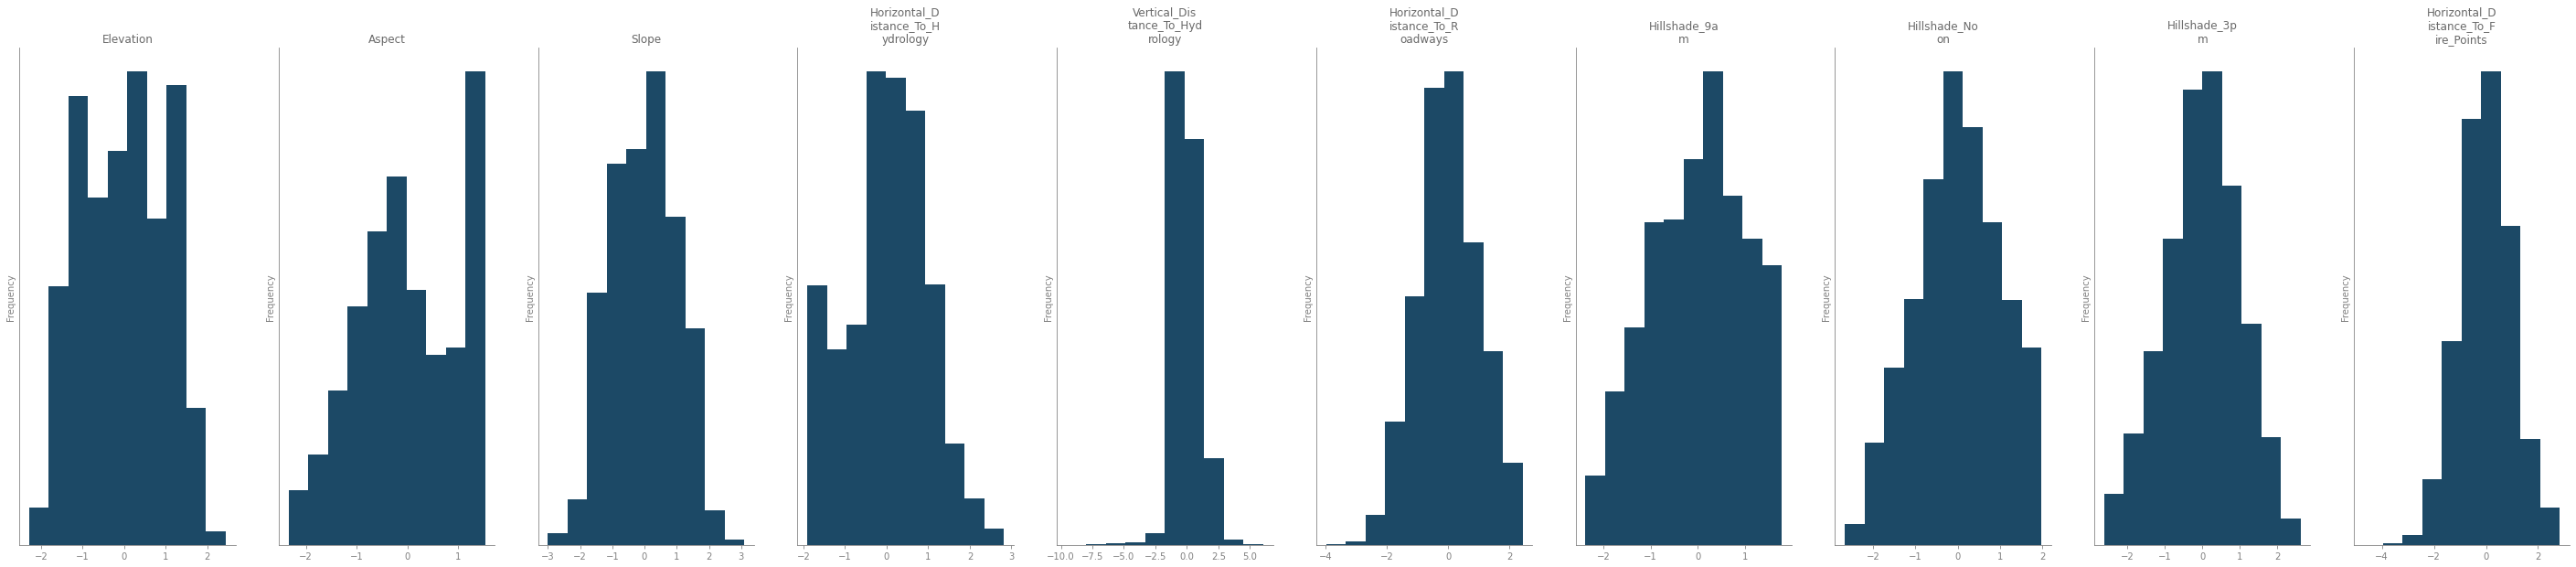

In [24]:
plot_histograms(continuous_features, train_X_transf)

Following transformation each continuous feature is certainly not pefectly normally distributed, but each of them have look much more well-distributed, and it is believable that the mean would now fall roughly in the center.

#### Binarize Each Transformed Variable

In [25]:
# Binarize the data
train_X_transf = binarize_data(train_X_transf, train_X_transf.columns) # Binarize all continuous features
dev_X_transf = binarize_data(dev_X_transf, train_X_transf.columns)

# Combine the new, transformed columns with original DF
train_X_full = X_train.merge(train_X_transf, how='left', on = X_train.index)\
                      .set_index(X_train.index)\
                      .drop(['key_0'], axis = 1)

dev_X_full = X_dev.merge(dev_X_transf, how='left', on = X_dev.index)\
                  .set_index(X_dev.index)\
                  .drop(['key_0'], axis = 1)

#### Bernoulli NB with Binarized/transformed continuous features, and binary features

Following transformation and binarization of the continuous features, now we can use Bernoulli Naive Bayes to model all of the features.

In [26]:
# Transformed/binarized features + binary features
model_features = list(train_X_transf.columns) + binary_features

# Fit Bernoulli Naive Bayes
bNB = BernoulliNB().fit(train_X_full[model_features], np.array(y_train).ravel())    # Fit
bNB_pred = bNB.predict(dev_X_full[model_features])                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')                    # F1
bNB_accur = bNB.score(dev_X_full[model_features], y_dev)                            # Accuracy

print('Bernoulli Naive Bayes (All Features transformed/binarized + Binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (All Features transformed/binarized + Binary features)
F1: 0.578 
Accuracy: 0.583


Following transformation and binarization, our model score has decreased compared to the "well-distributed" binarized model.

Next, will try dropping a few columns that seem to be over-predicting Cover Type 6.

In [27]:
# Transformed/binarized features + binary features
model_features = list(train_X_transf.columns) + binary_features
model_features.remove('Soil_Type22')
model_features.remove('Soil_Type23')
model_features.remove('Soil_Type29')
model_features.remove('Soil_Type32')
model_features.remove('Soil_Type38')
model_features.remove('Soil_Type39')

# Fit Bernoulli Naive Bayes
bNB = BernoulliNB().fit(train_X_full[model_features], np.array(y_train).ravel())    # Fit
bNB_pred = bNB.predict(dev_X_full[model_features])                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')                   # F1
bNB_accur = bNB.score(dev_X_full[model_features], y_dev)                            # Accuracy

print('Bernoulli Naive Bayes (All Features transformed/binarized + Binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (All Features transformed/binarized + Binary features)
F1: 0.519 
Accuracy: 0.540


Since that decreased our F1 Score from 0.578 to 0.519, let's revert back to our model without the dropped soil types above and try searching for an "ideal" alpha value for smoothing. We will use the `GridSearchCV` function to do this.

In [28]:
from sklearn.model_selection import GridSearchCV

model_features = list(train_X_transf.columns) + binary_features

def GSCV(alphas):
    model = GridSearchCV(estimator = BernoulliNB(),
                         param_grid = alphas,
                         cv = 5,
                         scoring = 'accuracy',
                         iid = False)
    return model.fit(train_X_full[model_features], np.array(y_train).ravel())

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = GSCV(alphas)
print("Best alpha = ", nb.best_score_)

Best alpha =  0.5783728335252256


/Users/brennagiacchino/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Next, plugging in the best alpha, test the model.

#### Use Grid Search to choose best parameters for Model 6

In [29]:
# Transformed/binarized features + binary features
model_features = list(train_X_transf.columns) + binary_features

# Fit Bernoulli Naive Bayes
bNB = BernoulliNB(alpha = nb.best_score_).fit(train_X_full[model_features], np.array(y_train).ravel())    # Fit
bNB_pred = bNB.predict(dev_X_full[model_features])                                  # Predict

bNB_f1 = metrics.f1_score(y_dev, bNB_pred, average = 'weighted')                   # F1
bNB_accur = bNB.score(dev_X_full[model_features], y_dev)                            # Accuracy

print('Bernoulli Naive Bayes (All Features transformed/binarized + Binary features)')
print(f'F1: {bNB_f1:.3f} \nAccuracy: {bNB_accur:.3f}')

Bernoulli Naive Bayes (All Features transformed/binarized + Binary features)
F1: 0.578 
Accuracy: 0.583


# Summary